### Libraries

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# (Optional) If you're working inside Jupyter
%load_ext autoreload
%autoreload 2
%matplotlib inline



In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


In [33]:
input_data = pd.read_csv("TimesFM_120_diff_2019_2023_residual_normalized_denormalized.csv")

In [34]:
predicted_sced_rolled = input_data.drop(columns=["Unnamed: 0"])

In [35]:
predicted_sced_rolled

,sced_time_stamp_local,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,2019-01-09 00:00:00,14.904335,14.856867,14.804567,14.761505,14.778816,14.767977,14.697033,14.648288,14.603667,...,20.262600,20.251250,20.208008,20.219090,20.283094,20.308826,20.249482,20.285249,20.323092,17.548107
1,2019-01-09 00:05:00,16.700947,16.633308,16.552786,16.539985,16.485066,16.448083,16.377838,16.286244,16.192334,...,20.796287,20.808766,20.729417,20.741490,20.747853,20.807025,20.813063,20.859163,18.058910,18.171945
2,2019-01-09 00:10:00,16.860619,16.821204,16.750792,16.710410,16.603721,16.489480,16.343050,16.164303,16.023681,...,20.751536,20.761647,20.683599,20.678557,20.690354,20.763386,20.802026,18.019122,18.117164,18.195980
3,2019-01-09 00:15:00,17.061385,17.027319,16.938956,16.899383,16.796634,16.677353,16.539714,16.376556,15.635849,...,20.922008,20.943844,20.861734,20.876063,20.880223,21.009878,18.179298,18.338295,18.366042,18.415348
4,2019-01-09 00:20:00,16.994793,16.923139,16.833889,16.775167,16.650890,16.518467,16.334197,15.520321,15.389042,...,20.818146,20.808893,20.729079,20.736114,20.807758,18.053520,18.101355,18.236680,18.219161,18.236476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523459,2023-12-31 13:35:00,11.222121,11.153143,11.003984,10.964771,10.406129,10.207119,10.122379,10.052761,9.886681,...,13.816748,13.714606,14.073501,13.924111,13.868442,13.811271,13.811950,13.782188,13.784018,13.767511
523460,2023-12-31 13:40:00,11.770532,11.672510,11.502467,11.055709,10.909261,10.714956,10.629254,10.563789,10.411473,...,13.723091,14.102182,13.999675,13.864083,13.807504,13.759758,13.752029,13.694109,13.708415,13.705348
523461,2023-12-31 13:45:00,11.305092,11.230844,10.686851,10.664467,10.543892,10.363391,10.277407,10.237837,10.108688,...,13.724672,13.596072,13.484247,13.361977,13.285192,13.215158,13.192279,13.137909,13.171703,13.165296
523462,2023-12-31 13:50:00,11.442759,10.994090,10.868528,10.894445,10.836866,10.664036,10.598944,10.580883,10.466655,...,13.770367,13.712891,13.629569,13.556331,13.502095,13.415098,13.433138,13.413437,13.437833,13.356115


In [36]:
all_data = pd.read_csv("data_all_features_raw.csv")

In [37]:
all_data["net_load"] = all_data["Load_load"] - all_data["Fuel_solar"] - all_data["Fuel_wind"]

In [38]:
# Rename timestamp column for clarity
all_data = all_data.rename(columns={"Unnamed: 0": "timestamp"})
# Make sure the timestamp is in datetime format
all_data["timestamp"] = pd.to_datetime(all_data["timestamp"])

In [39]:

sced_data = all_data[["timestamp", 'SCED_system_lambda']]
hydro_data = all_data[["timestamp", 'Fuel_hydro']]
nuclear_data = all_data[["timestamp", "Fuel_nuclear"]]
storage_data = all_data[["timestamp", "Fuel_power_storage"]]
solar_data = all_data[["timestamp", "Fuel_solar"]]
wind_data = all_data[["timestamp", "Fuel_wind"]]
ng_data = all_data[["timestamp", "Fuel_natural_gas"]]
load_data = all_data[["timestamp", "Load_load"]]
net_load_data = all_data[["timestamp", "net_load"]]

In [40]:
import pandas as pd

def make_rolled_target(df, value_col, timestamp_col, look_ahead):
    """
    Creates a rolling look-ahead target DataFrame from a time series.
    
    Args:
        df (pd.DataFrame): Original DataFrame.
        value_col (str): Name of the column containing the values to roll.
        timestamp_col (str): Name of the timestamp column.
        look_ahead (int): Number of future steps to include.
    
    Returns:
        pd.DataFrame: A new DataFrame with 'timestamp' and look-ahead target columns.
    """
    
    # Create rolling horizon
    rolled = pd.DataFrame([
        pd.Series(df[value_col].iloc[i+1:i+1+look_ahead].values)
        for i in range(len(df) - look_ahead)
    ])
    rolled.columns = [f"{i+1}" for i in range(look_ahead)]
    
    # Add timestamp of starting point
    rolled["timestamp"] = df[timestamp_col].iloc[:len(rolled)].values
    
    # Reorder columns
    rolled = rolled[["timestamp"] + [col for col in rolled.columns if col != "timestamp"]]
    
    return rolled


In [41]:
look_ahead = 120  # or any value you choose
rolled_sced = make_rolled_target(sced_data, "SCED_system_lambda", "timestamp", look_ahead)
hydro_rolled = make_rolled_target(hydro_data, "Fuel_hydro", "timestamp", look_ahead)
nuclear_rolled = make_rolled_target(nuclear_data, "Fuel_nuclear", "timestamp", look_ahead)
storage_rolled = make_rolled_target(storage_data, "Fuel_power_storage", "timestamp", look_ahead)
solar_rolled = make_rolled_target(solar_data, "Fuel_solar", "timestamp", look_ahead)
wind_rolled = make_rolled_target(wind_data, "Fuel_wind", "timestamp", look_ahead)
ng_rolled = make_rolled_target(ng_data, "Fuel_natural_gas", "timestamp", look_ahead)
load_rolled = make_rolled_target(load_data, "Load_load", "timestamp", look_ahead)
net_load_rolled = make_rolled_target(net_load_data, "net_load", "timestamp", look_ahead)


In [42]:
dap_data = all_data[["timestamp", "DAP_SystemLambda"]]
rolled_dap = make_rolled_target(dap_data, "DAP_SystemLambda", "timestamp", look_ahead)

In [43]:
start_date = pd.Timestamp("2019-01-09 00:00:00")
end_date = pd.Timestamp("2023-12-31 13:55:00")

# For one DataFrame
rolled_sced = rolled_sced[(rolled_sced["timestamp"] >= start_date) & (rolled_sced["timestamp"] <= end_date)]
hydro_rolled = hydro_rolled[(hydro_rolled["timestamp"] >= start_date) & (hydro_rolled["timestamp"] <= end_date)]
nuclear_rolled = nuclear_rolled[(nuclear_rolled["timestamp"] >= start_date) & (nuclear_rolled["timestamp"] <= end_date)]
storage_rolled = storage_rolled[(storage_rolled["timestamp"] >= start_date) & (storage_rolled["timestamp"] <= end_date)]
solar_rolled = solar_rolled[(solar_rolled["timestamp"] >= start_date) & (solar_rolled["timestamp"] <= end_date)]
wind_rolled = wind_rolled[(wind_rolled["timestamp"] >= start_date) & (wind_rolled["timestamp"] <= end_date)]
ng_rolled = ng_rolled[(ng_rolled["timestamp"] >= start_date) & (ng_rolled["timestamp"] <= end_date)]
load_rolled = load_rolled[(load_rolled["timestamp"] >= start_date) & (load_rolled["timestamp"] <= end_date)]
net_load_rolled = net_load_rolled[(net_load_rolled["timestamp"] >= start_date) & (net_load_rolled["timestamp"] <= end_date)]


In [44]:
import pandas as pd
import numpy as np

# ---- Step 1: Load and Preprocess ----
# (Assume you already have your rolling window dataframes like hydro_rolled, wind_rolled, sced_rolled, etc.)

# Define the list of all input feature rolled DataFrames
input_feature_rolled_list = [
    solar_rolled,
    wind_rolled,
    load_rolled,
    net_load_rolled,
    predicted_sced_rolled,
]

# ---- Step 2: Build Input Tensor X ----
# For each feature, extract the future window columns ('1' to '120')
X_list = []

for df in input_feature_rolled_list:
    X_feature = df[[str(i) for i in range(1, 121)]].values  # (N, 120)
    X_list.append(X_feature)

# Stack features together
X = np.stack(X_list, axis=-1)  # final shape (N, 120, num_features)

# ---- Step 3: Build Target Tensor y ----
y = rolled_sced[[str(i) for i in range(1, 121)]].values  # (N, 10)

# ---- Step 4: Store timestamps separately ----
timestamps = pd.to_datetime(rolled_sced["timestamp"].values[:len(X)])  # (N,)

# ---- Step 5: Define Time Ranges ----
train_start = pd.Timestamp("2019-01-09 00:00:00")
train_end = pd.Timestamp("2021-12-31 23:55:00")
eval_start = pd.Timestamp("2022-01-01 00:00:00")
eval_end = pd.Timestamp("2022-12-31 23:55:00")
test_start = pd.Timestamp("2023-01-01 00:00:00")
test_end = pd.Timestamp("2023-12-31 13:55:00")

# ---- Step 6: Create Masks ----
train_mask = (timestamps >= train_start) & (timestamps <= train_end)
eval_mask = (timestamps >= eval_start) & (timestamps <= eval_end)
test_mask = (timestamps >= test_start) 

# ---- Step 7: Split into Train/Eval/Test ----
X_train, y_train, ts_train = X[train_mask], y[train_mask], timestamps[train_mask]
X_eval, y_eval, ts_eval = X[eval_mask], y[eval_mask], timestamps[eval_mask]
X_test, y_test, ts_test = X[test_mask], y[test_mask], timestamps[test_mask]

# ---- Step 8: (Optional) Check final shapes ----
print(f"Train X: {X_train.shape}, y: {y_train.shape}")
print(f"Eval X: {X_eval.shape}, y: {y_eval.shape}")
print(f"Test X: {X_test.shape}, y: {y_test.shape}")


Train X: (313344, 120, 5), y: (313344, 120)
Eval X: (105120, 120, 5), y: (105120, 120)
Test X: (105000, 120, 5), y: (105000, 120)


# Normalization

In [45]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def standardize_rolled_inputs(X_train, X_eval, X_test):
    """
    Standardizes 3D input arrays (N, T, F) by flattening across time,
    fitting scaler only on training set, and applying it consistently.
    """
    N_train, T, F = X_train.shape

    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, F)
    scaler.fit(X_train_flat)

    # Transform and reshape back
    X_train_scaled = scaler.transform(X_train_flat).reshape(N_train, T, F)
    X_eval_scaled = scaler.transform(X_eval.reshape(-1, F)).reshape(X_eval.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, F)).reshape(X_test.shape)

    return X_train_scaled, X_eval_scaled, X_test_scaled, scaler


In [46]:
X_train_scaled, X_eval_scaled, X_test_scaled, scaler = standardize_rolled_inputs(
    X_train, X_eval, X_test
)

In [47]:
X_train_mlp = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
X_eval_mlp = X_eval_scaled.reshape(X_eval_scaled.shape[0], -1)
X_test_mlp = X_test_scaled.reshape(X_test_scaled.shape[0], -1)


In [48]:
print(X_test_mlp.shape)

(105000, 600)


# Model Building

In [49]:
from MLP import MLPModel

new_model = MLPModel(
    input_shape=120*5,    # 5 features
    output_shape=120,   # 1 price per time step
    hidden_layers=[512, 512, 512]  # or [256, 256]
)

mlp_model = new_model.get_model()
mlp_model.to(device)


MLPModel(
  (model): Sequential(
    (0): Linear(in_features=600, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=120, bias=True)
  )
)

In [50]:
from ModelTrainer import ModelTrainer
from losses import fluctuation_loss  # or define it above in your notebook

trainer = ModelTrainer(
    model=mlp_model,
    features_training_data=X_train_scaled,
    target_training_data=y_train,
    features_eval_data=X_eval_scaled,
    target_eval_data=y_eval,
    device=device,
    loss_fn=lambda pred, target: fluctuation_loss(pred, target, alpha=0.2)
)


trainer.train(epochs=100, batch_size=32, patience=50, learning_rate=5e-4)


Epoch 1: Train Loss = 44860.7814, Eval Loss = 25259.3184
Epoch 2: Train Loss = 34737.5868, Eval Loss = 23637.4023
Epoch 3: Train Loss = 28831.4944, Eval Loss = 25121.3633
Epoch 4: Train Loss = 25380.5309, Eval Loss = 26950.5762
Epoch 5: Train Loss = 22705.0442, Eval Loss = 27032.2559
Epoch 6: Train Loss = 21027.8193, Eval Loss = 26826.6172
Epoch 7: Train Loss = 19672.9824, Eval Loss = 26727.0684
Epoch 8: Train Loss = 18742.1724, Eval Loss = 29525.5801
Epoch 9: Train Loss = 17960.3682, Eval Loss = 26410.4727
Epoch 10: Train Loss = 17360.6236, Eval Loss = 25990.1777
Epoch 11: Train Loss = 17048.4625, Eval Loss = 27299.6074
Epoch 12: Train Loss = 16567.0083, Eval Loss = 26619.8145
Epoch 13: Train Loss = 16190.5314, Eval Loss = 27144.2949
Epoch 14: Train Loss = 15910.7959, Eval Loss = 27329.2070
Epoch 15: Train Loss = 15591.1184, Eval Loss = 28171.7695
Epoch 16: Train Loss = 15341.4495, Eval Loss = 26782.4043
Epoch 17: Train Loss = 14985.3512, Eval Loss = 26749.1992
Epoch 18: Train Loss = 

In [58]:
import optuna
from MLP import MLPModel
from ModelTrainer import ModelTrainer
from losses import fluctuation_loss

def objective(trial):
    # Suggest hyperparameters
    hidden_dim = trial.suggest_categorical("hidden_dim", [256, 512, 768])
    n_layers = trial.suggest_int("n_layers", 2, 4)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    alpha = trial.suggest_uniform("alpha", 0.1, 0.5)

    # Build hidden layers
    hidden_layers = [hidden_dim] * n_layers

    # Build model
    model = MLPModel(input_shape=120*5, output_shape=120, hidden_layers=hidden_layers).get_model().to(device)

    # Trainer
    trainer = ModelTrainer(
        model=model,
        features_training_data=X_train_scaled,
        target_training_data=y_train,
        features_eval_data=X_eval_scaled,
        target_eval_data=y_eval,
        device=device,
        loss_fn=lambda pred, target: fluctuation_loss(pred, target, alpha=alpha)
    )

    # Train for a few epochs
    trainer.train(epochs=50, batch_size=32, patience=10, learning_rate=lr)

    # Return final eval loss (or early stopping best)
    return trainer.history['eval_loss'][-1]


In [59]:

study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner()
)
study.optimize(objective, n_trials=50)


[I 2025-05-03 22:22:13,949] A new study created in memory with name: no-name-8390240c-bedf-4ed3-a074-e4e7a343ddfc
/var/folders/wd/tgznb8111md97qlw9yqd793m0000gn/T/ipykernel_83673/4263376427.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
/var/folders/wd/tgznb8111md97qlw9yqd793m0000gn/T/ipykernel_83673/4263376427.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform("alpha", 0.1, 0.5)


Epoch 1: Train Loss = 46765.1271, Eval Loss = 24151.6836
Epoch 2: Train Loss = 34949.8253, Eval Loss = 24404.8242
Epoch 3: Train Loss = 29375.8656, Eval Loss = 27718.3418
Epoch 4: Train Loss = 25902.4167, Eval Loss = 24680.7168
Epoch 5: Train Loss = 23445.7619, Eval Loss = 24982.5938
Epoch 6: Train Loss = 21837.2015, Eval Loss = 27377.2207
Epoch 7: Train Loss = 20900.2021, Eval Loss = 27330.7324
Epoch 8: Train Loss = 19967.0826, Eval Loss = 24779.2031
Epoch 9: Train Loss = 19215.8081, Eval Loss = 25113.6426
Epoch 10: Train Loss = 18651.2615, Eval Loss = 25915.6738


[I 2025-05-03 22:28:27,630] Trial 0 finished with value: 24994.4921875 and parameters: {'hidden_dim': 512, 'n_layers': 3, 'lr': 0.0006154539709220337, 'alpha': 0.3394664152093499}. Best is trial 0 with value: 24994.4921875.


Epoch 11: Train Loss = 18185.8148, Eval Loss = 24994.4922
Early stopping triggered at epoch 11
Epoch 1: Train Loss = 45613.9842, Eval Loss = 22613.3379
Epoch 2: Train Loss = 37599.8510, Eval Loss = 23701.0059
Epoch 3: Train Loss = 32166.2852, Eval Loss = 26916.0762
Epoch 4: Train Loss = 28820.4753, Eval Loss = 25557.9141
Epoch 5: Train Loss = 26309.4215, Eval Loss = 25572.7480
Epoch 6: Train Loss = 24670.3920, Eval Loss = 24240.6230
Epoch 7: Train Loss = 23421.0579, Eval Loss = 25676.1543
Epoch 8: Train Loss = 22573.7302, Eval Loss = 26396.7266
Epoch 9: Train Loss = 21712.7519, Eval Loss = 25913.5117
Epoch 10: Train Loss = 21046.7117, Eval Loss = 27896.2695


[I 2025-05-03 22:36:23,199] Trial 1 finished with value: 25776.7265625 and parameters: {'hidden_dim': 768, 'n_layers': 2, 'lr': 0.0003457967954434044, 'alpha': 0.3756355235916683}. Best is trial 0 with value: 24994.4921875.


Epoch 11: Train Loss = 20467.2859, Eval Loss = 25776.7266
Early stopping triggered at epoch 11
Epoch 1: Train Loss = 47843.8891, Eval Loss = 24572.4863
Epoch 2: Train Loss = 38023.7493, Eval Loss = 23287.9727
Epoch 3: Train Loss = 31664.5648, Eval Loss = 26526.3047
Epoch 4: Train Loss = 27685.1261, Eval Loss = 30501.0762
Epoch 5: Train Loss = 24886.6743, Eval Loss = 27823.2539
Epoch 6: Train Loss = 23258.6215, Eval Loss = 27795.5645
Epoch 7: Train Loss = 22139.6792, Eval Loss = 31415.4023
Epoch 8: Train Loss = 20893.8239, Eval Loss = 25984.9434
Epoch 9: Train Loss = 20188.1266, Eval Loss = 27524.5645
Epoch 10: Train Loss = 19427.0067, Eval Loss = 28095.9766
Epoch 11: Train Loss = 19033.8758, Eval Loss = 26578.6758


[I 2025-05-03 22:43:47,291] Trial 2 finished with value: 27736.9765625 and parameters: {'hidden_dim': 512, 'n_layers': 4, 'lr': 0.00026866235768253113, 'alpha': 0.352489639532136}. Best is trial 0 with value: 24994.4921875.


Epoch 12: Train Loss = 18655.3902, Eval Loss = 27736.9766
Early stopping triggered at epoch 12
Epoch 1: Train Loss = 46418.5191, Eval Loss = 24856.9883
Epoch 2: Train Loss = 39309.0321, Eval Loss = 24248.7793
Epoch 3: Train Loss = 35110.7644, Eval Loss = 25364.9141
Epoch 4: Train Loss = 32047.1875, Eval Loss = 23978.0449
Epoch 5: Train Loss = 29829.7338, Eval Loss = 23830.3477
Epoch 6: Train Loss = 27961.1614, Eval Loss = 23304.8262
Epoch 7: Train Loss = 26394.9718, Eval Loss = 25875.3945
Epoch 8: Train Loss = 25119.1981, Eval Loss = 25993.1230
Epoch 9: Train Loss = 24007.5111, Eval Loss = 26451.0449
Epoch 10: Train Loss = 23121.3154, Eval Loss = 26306.0859
Epoch 11: Train Loss = 22401.3931, Eval Loss = 26083.6602
Epoch 12: Train Loss = 21740.9415, Eval Loss = 25197.4160
Epoch 13: Train Loss = 21128.9654, Eval Loss = 25780.2930
Epoch 14: Train Loss = 20693.1473, Eval Loss = 25045.0859
Epoch 15: Train Loss = 20225.5868, Eval Loss = 25591.1289


[I 2025-05-03 22:50:17,094] Trial 3 finished with value: 25017.0 and parameters: {'hidden_dim': 256, 'n_layers': 2, 'lr': 0.000359935154427567, 'alpha': 0.2533416909395281}. Best is trial 0 with value: 24994.4921875.


Epoch 16: Train Loss = 19921.1550, Eval Loss = 25017.0000
Early stopping triggered at epoch 16
Epoch 1: Train Loss = 50963.0113, Eval Loss = 21859.5508
Epoch 2: Train Loss = 46893.6097, Eval Loss = 22033.6152
Epoch 3: Train Loss = 44416.3369, Eval Loss = 22191.1953
Epoch 4: Train Loss = 42434.2317, Eval Loss = 22736.8848
Epoch 5: Train Loss = 40952.7158, Eval Loss = 22997.7383
Epoch 6: Train Loss = 39638.2874, Eval Loss = 24361.1562
Epoch 7: Train Loss = 38405.7516, Eval Loss = 24253.8828
Epoch 8: Train Loss = 37282.7189, Eval Loss = 24619.6074
Epoch 9: Train Loss = 36212.5179, Eval Loss = 24587.9766
Epoch 10: Train Loss = 34933.5191, Eval Loss = 25622.0332


[I 2025-05-03 22:55:47,756] Trial 4 finished with value: 25770.91015625 and parameters: {'hidden_dim': 512, 'n_layers': 2, 'lr': 7.791381144847803e-05, 'alpha': 0.3739887485493244}. Best is trial 0 with value: 24994.4921875.


Epoch 11: Train Loss = 33672.4145, Eval Loss = 25770.9102
Early stopping triggered at epoch 11
Epoch 1: Train Loss = 46545.2036, Eval Loss = 21573.7422
Epoch 2: Train Loss = 38595.8595, Eval Loss = 22985.4590
Epoch 3: Train Loss = 33682.8023, Eval Loss = 23974.7070
Epoch 4: Train Loss = 30720.9784, Eval Loss = 25485.2422
Epoch 5: Train Loss = 28207.1048, Eval Loss = 25019.3359
Epoch 6: Train Loss = 26083.9019, Eval Loss = 25249.4844
Epoch 7: Train Loss = 24491.7499, Eval Loss = 24991.9238
Epoch 8: Train Loss = 23453.2252, Eval Loss = 25614.5703
Epoch 9: Train Loss = 22521.6156, Eval Loss = 24446.4531
Epoch 10: Train Loss = 21800.0795, Eval Loss = 27874.8105


[I 2025-05-03 23:01:18,003] Trial 5 finished with value: 28333.59375 and parameters: {'hidden_dim': 512, 'n_layers': 2, 'lr': 0.00032932869804636256, 'alpha': 0.30787307654378643}. Best is trial 0 with value: 24994.4921875.


Epoch 11: Train Loss = 21147.9276, Eval Loss = 28333.5938
Early stopping triggered at epoch 11
Epoch 1: Train Loss = 46587.9985, Eval Loss = 24664.7344
Epoch 2: Train Loss = 37771.9721, Eval Loss = 22934.8555
Epoch 3: Train Loss = 32385.5203, Eval Loss = 29758.9590
Epoch 4: Train Loss = 29248.5729, Eval Loss = 25216.7520
Epoch 5: Train Loss = 26896.5641, Eval Loss = 26169.3008
Epoch 6: Train Loss = 25250.3870, Eval Loss = 24768.8223
Epoch 7: Train Loss = 24030.0971, Eval Loss = 26066.6484
Epoch 8: Train Loss = 22967.0364, Eval Loss = 24465.7188
Epoch 9: Train Loss = 22309.2487, Eval Loss = 26104.0742
Epoch 10: Train Loss = 21664.4791, Eval Loss = 26699.1562
Epoch 11: Train Loss = 20935.7819, Eval Loss = 27035.0605


[I 2025-05-03 23:06:03,269] Trial 6 finished with value: 26366.451171875 and parameters: {'hidden_dim': 256, 'n_layers': 2, 'lr': 0.0006675844616546189, 'alpha': 0.34861663625945627}. Best is trial 0 with value: 24994.4921875.


Epoch 12: Train Loss = 20478.8897, Eval Loss = 26366.4512
Early stopping triggered at epoch 12
Epoch 1: Train Loss = 47334.4054, Eval Loss = 26197.4531
Epoch 2: Train Loss = 35848.6531, Eval Loss = 25921.0312
Epoch 3: Train Loss = 30254.5967, Eval Loss = 27415.1230
Epoch 4: Train Loss = 26724.3965, Eval Loss = 27371.1543
Epoch 5: Train Loss = 24104.9792, Eval Loss = 25881.0859
Epoch 6: Train Loss = 22508.6419, Eval Loss = 26043.0605
Epoch 7: Train Loss = 21327.1925, Eval Loss = 27898.9922
Epoch 8: Train Loss = 20579.8846, Eval Loss = 26695.2500
Epoch 9: Train Loss = 19828.5374, Eval Loss = 26779.9727
Epoch 10: Train Loss = 19389.0207, Eval Loss = 27424.7617
Epoch 11: Train Loss = 18687.9516, Eval Loss = 26299.5625
Epoch 12: Train Loss = 18367.4818, Eval Loss = 25397.0625
Epoch 13: Train Loss = 17928.2349, Eval Loss = 26117.3301
Epoch 14: Train Loss = 17675.2489, Eval Loss = 25385.2617
Epoch 15: Train Loss = 17357.3721, Eval Loss = 27463.4668
Epoch 16: Train Loss = 17138.4453, Eval Loss

[I 2025-05-03 23:21:04,132] Trial 7 finished with value: 25524.48828125 and parameters: {'hidden_dim': 512, 'n_layers': 3, 'lr': 0.0004762252859426671, 'alpha': 0.39493125280468655}. Best is trial 0 with value: 24994.4921875.


Epoch 27: Train Loss = 15000.7082, Eval Loss = 25524.4883
Early stopping triggered at epoch 27
Epoch 1: Train Loss = 47438.2100, Eval Loss = 22446.6543
Epoch 2: Train Loss = 38000.9697, Eval Loss = 22635.7812
Epoch 3: Train Loss = 31733.4065, Eval Loss = 24215.6445
Epoch 4: Train Loss = 28069.8341, Eval Loss = 28799.7676
Epoch 5: Train Loss = 25301.9131, Eval Loss = 26641.2070
Epoch 6: Train Loss = 23314.7614, Eval Loss = 28028.5312
Epoch 7: Train Loss = 21786.3034, Eval Loss = 28825.8125
Epoch 8: Train Loss = 20976.1076, Eval Loss = 27951.2949
Epoch 9: Train Loss = 19830.9770, Eval Loss = 26665.3027
Epoch 10: Train Loss = 19120.6882, Eval Loss = 25473.0664


[I 2025-05-03 23:32:02,903] Trial 8 finished with value: 26698.98046875 and parameters: {'hidden_dim': 768, 'n_layers': 4, 'lr': 0.00013447358351102544, 'alpha': 0.2682570150876734}. Best is trial 0 with value: 24994.4921875.


Epoch 11: Train Loss = 18540.2974, Eval Loss = 26698.9805
Early stopping triggered at epoch 11
Epoch 1: Train Loss = 54533.3452, Eval Loss = 22292.3789
Epoch 2: Train Loss = 49288.4257, Eval Loss = 22674.9375
Epoch 3: Train Loss = 47957.9637, Eval Loss = 22775.8262
Epoch 4: Train Loss = 46647.6185, Eval Loss = 23522.5059
Epoch 5: Train Loss = 45553.3656, Eval Loss = 24423.3789
Epoch 6: Train Loss = 44243.8856, Eval Loss = 25094.8301
Epoch 7: Train Loss = 43073.8043, Eval Loss = 27694.6348


[W 2025-05-03 23:35:58,967] Trial 9 failed with parameters: {'hidden_dim': 256, 'n_layers': 4, 'lr': 2.64400703109689e-05, 'alpha': 0.4673732103976839} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/hongyuli/miniconda3/envs/red-river-energy/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/wd/tgznb8111md97qlw9yqd793m0000gn/T/ipykernel_83673/4263376427.py", line 31, in objective
    trainer.train(epochs=50, batch_size=32, patience=10, learning_rate=lr)
  File "/Users/hongyuli/Documents/Research/Electricity/code/ModelTrainer.py", line 43, in train
    optimizer.zero_grad()
  File "/Users/hongyuli/miniconda3/envs/red-river-energy/lib/python3.11/site-packages/torch/_compile.py", line 41, in inner
    @functools.wraps(fn)
    
KeyboardInterrupt
[W 2025-05-03 23:35:58,981] Trial 9 failed with value None.


KeyboardInterrupt: 

In [ ]:
print("Best hyperparameters:", study.best_trial.params)


In [51]:
# predict

mlp_model.eval()
with torch.no_grad():
    y_pred = mlp_model(torch.tensor(X_test_mlp, dtype=torch.float32).to(device))


y_pred = y_pred.cpu().numpy()
errors = y_pred - y_test  # assuming y_test is numpy array
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(errors))

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")



Test MAE: 44.8259
Test RMSE: 257.4293


In [52]:
# Recreate test_mask using rolled_dap's timestamps
dap_timestamps = pd.to_datetime(rolled_dap["timestamp"])
test_start = pd.Timestamp("2023-01-01 00:00:00")
test_mask_dap = dap_timestamps >= test_start

# Then apply it to dap_test
dap_test = rolled_dap[[str(i) for i in range(1, 121)]].values
dap_test = dap_test[test_mask_dap]


In [53]:
dap_test

array([[10.8334, 10.8334, 10.8334, ..., 15.0522, 15.0522, 17.2491],
       [10.8334, 10.8334, 10.8334, ..., 15.0522, 17.2491, 17.2491],
       [10.8334, 10.8334, 10.8334, ..., 17.2491, 17.2491, 17.2491],
       ...,
       [14.4612, 14.4612, 13.861 , ..., 19.2456, 19.2456, 19.2456],
       [14.4612, 13.861 , 13.861 , ..., 19.2456, 19.2456, 19.2456],
       [13.861 , 13.861 , 13.861 , ..., 19.2456, 19.2456, 19.2456]])

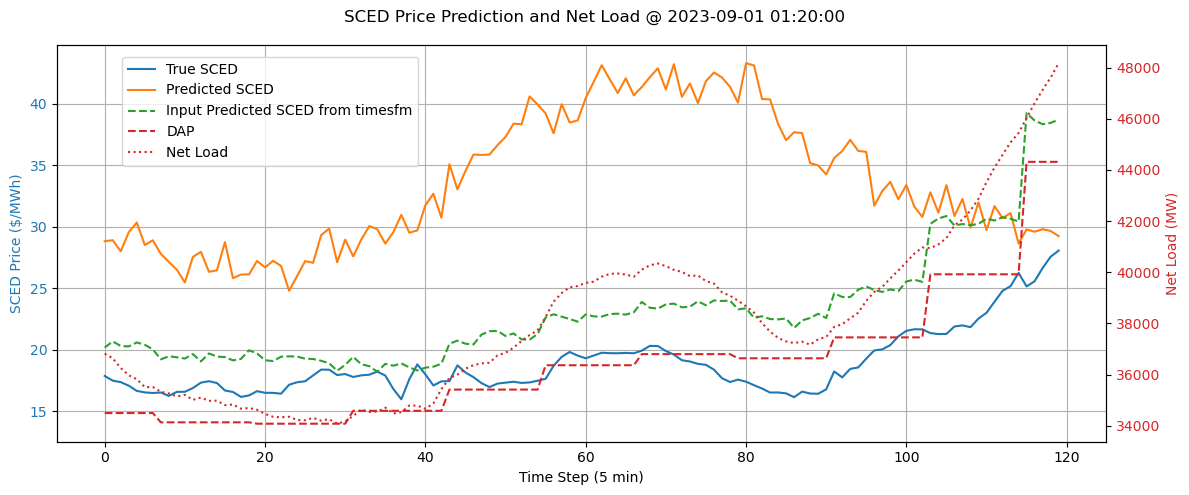

In [58]:
import matplotlib.pyplot as plt

idx =70000  # sample index to visualize

# Main data (prices)
timestamp = ts_test[idx]
true_sced = y_test[idx]
pred_sced = y_pred[idx]
dap_window = dap_test[idx]
input_pred_sced = X_test[idx, :, 4]

# Secondary data (net load)
net_load = X_test[idx, :, 3]  # assuming net_load is the 4th feature (index 3)
solar_load = X_test[idx, :, 0]  # assuming net_load is the 4th feature (index 3)
wind_load = X_test[idx, :, 1]  # assuming net_load is the 4th feature (index 3)

# ---- Plotting ----
fig, ax1 = plt.subplots(figsize=(12, 5))

# Left y-axis: SCED prices
ax1.plot(true_sced, label="True SCED", color="tab:blue")
ax1.plot(pred_sced, label="Predicted SCED", color="tab:orange")
ax1.plot(input_pred_sced, label="Input Predicted SCED from timesfm", color="tab:green", linestyle="--")
ax1.plot(dap_window, label="DAP", color="tab:red", linestyle="--")
ax1.set_xlabel("Time Step (5 min)")
ax1.set_ylabel("SCED Price ($/MWh)", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.grid(True)

# Right y-axis: Net Load
ax2 = ax1.twinx()
ax2.plot(net_load, label="Net Load", color="tab:red", linestyle=":")
ax2.set_ylabel("Net Load (MW)", color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")

# ---- Title and Legend ----
fig.suptitle(f"SCED Price Prediction and Net Load @ {timestamp}")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()


### Optimizing

In [59]:
len(y_pred)

105000

In [60]:
# add timestamp to the predictions
# Use appropriate timestamps from your DataFrame (e.g., 5-minute intervals)
timestamps = pd.date_range(
    start="2023-01-01 00:00:00",
    periods=105000,
    freq="5min"
)

# Columns are step 1, step 2, ..., step 10
columns = [f"step_{i+1}" for i in range(y_pred.shape[1])]

# Build DataFrame
sl_pred = pd.DataFrame(y_pred, columns=columns)
sl_pred["timestamps"] = timestamps
# Reorder to put "timestamps" first
sl_pred = sl_pred[["timestamps"] + [col for col in sl_pred.columns if col != "timestamps"]]



# Save to CSV files
sl_pred.to_csv('5min_dap_241h.csv')

In [54]:
sl_pred

,timestamps,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,...,step_111,step_112,step_113,step_114,step_115,step_116,step_117,step_118,step_119,step_120
0,2023-01-01 00:00:00,-2.648146,-2.390966,-2.349594,-2.343839,-2.326401,-2.321906,-1.985557,-1.454155,-1.615148,...,2.858775,2.740664,2.780005,13.032491,13.377475,13.262575,12.408667,17.013020,24.164930,20.830612
1,2023-01-01 00:05:00,-2.390966,-2.349594,-2.343839,-2.326401,-2.321906,-1.985557,-1.454155,-1.615148,-1.612673,...,2.740664,2.780005,13.032491,13.377475,13.262575,12.408667,17.013020,24.164930,20.830612,20.210316
2,2023-01-01 00:10:00,-2.349594,-2.343839,-2.326401,-2.321906,-1.985557,-1.454155,-1.615148,-1.612673,-1.451050,...,2.780005,13.032491,13.377475,13.262575,12.408667,17.013020,24.164930,20.830612,20.210316,19.526390
3,2023-01-01 00:15:00,-2.343839,-2.326401,-2.321906,-1.985557,-1.454155,-1.615148,-1.612673,-1.451050,-1.450721,...,13.032491,13.377475,13.262575,12.408667,17.013020,24.164930,20.830612,20.210316,19.526390,23.218176
4,2023-01-01 00:20:00,-2.326401,-2.321906,-1.985557,-1.454155,-1.615148,-1.612673,-1.451050,-1.450721,-1.453138,...,13.377475,13.262575,12.408667,17.013020,24.164930,20.830612,20.210316,19.526390,23.218176,24.094515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,2023-12-31 13:35:00,11.599060,11.692280,10.586460,11.005346,11.041732,10.374124,7.520594,8.271972,10.110160,...,12.066859,11.847058,12.209281,12.418777,12.466784,12.896057,12.776202,12.563949,12.807795,12.889796
104996,2023-12-31 13:40:00,11.692280,10.586460,11.005346,11.041732,10.374124,7.520594,8.271972,10.110160,10.947229,...,11.847058,12.209281,12.418777,12.466784,12.896057,12.776202,12.563949,12.807795,12.889796,12.632624
104997,2023-12-31 13:45:00,10.586460,11.005346,11.041732,10.374124,7.520594,8.271972,10.110160,10.947229,10.220093,...,12.209281,12.418777,12.466784,12.896057,12.776202,12.563949,12.807795,12.889796,12.632624,12.572374
104998,2023-12-31 13:50:00,11.005346,11.041732,10.374124,7.520594,8.271972,10.110160,10.947229,10.220093,7.666133,...,12.418777,12.466784,12.896057,12.776202,12.563949,12.807795,12.889796,12.632624,12.572374,12.493818


In [94]:
print(sl_pred)

                            0          1          2          3          4   \
2023-01-01 23:55:00  -0.943643  -1.510712  -2.383256  -1.734692   1.032408   
2023-01-02 00:00:00  -1.579532  -2.412360  -4.080081  -3.691894  -0.212925   
2023-01-02 00:05:00  -1.952366  -2.048961  -4.300113  -2.235637  -0.612865   
2023-01-02 00:10:00  -1.642491  -1.067345  -3.787768  -1.397984   0.443273   
2023-01-02 00:15:00  -2.357398  -1.111841  -4.189584  -1.638471  -0.474079   
...                        ...        ...        ...        ...        ...   
2023-12-31 15:35:00  13.642232  14.620449  14.273226  14.796878  14.870831   
2023-12-31 15:40:00  14.024353  14.647687  14.478355  14.952069  15.014936   
2023-12-31 15:45:00  14.471080  15.430356  15.126199  15.246523  15.342616   
2023-12-31 15:50:00  13.736179  14.549651  14.506347  13.951535  14.495383   
2023-12-31 15:55:00  13.665600  13.867071  14.219832  13.984599  14.115159   

                            5          6          7          8 

In [77]:
pred_df = sl_pred.copy()

In [63]:
# prepare the nodal real-time price in the required shape
actual = pd.read_csv('lmp_WAKEWE_ALL_2023.csv')
actual_rolled = pd.DataFrame([pd.Series(actual['price'].iloc[i+1:i+1+look_ahead].values) for i in range(len(actual) - look_ahead)])
actual_rolled.columns = [f'{i+1}' for i in range(look_ahead)]
actual_rolled['timestamp'] = actual['timestamp'].iloc[:len(actual_rolled)].values
actual_rolled = actual_rolled[['timestamp'] + [col for col in actual_rolled.columns if col != 'timestamp']]
actual_rolled = actual_rolled.iloc[:,:look_ahead+1]

In [64]:
actual_rolled

,timestamp,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,1/1/23 0:00,-2.65,-2.39,-2.35,-2.34,-2.33,-2.33,-2.02,-1.54,-1.69,...,2.86,2.74,2.78,9.25,9.13,9.12,9.26,11.77,19.33,20.83
1,1/1/23 0:05,-2.39,-2.35,-2.34,-2.33,-2.33,-2.02,-1.54,-1.69,-1.69,...,2.74,2.78,9.25,9.13,9.12,9.26,11.77,19.33,20.83,20.21
2,1/1/23 0:10,-2.35,-2.34,-2.33,-2.33,-2.02,-1.54,-1.69,-1.69,-1.53,...,2.78,9.25,9.13,9.12,9.26,11.77,19.33,20.83,20.21,19.53
3,1/1/23 0:15,-2.34,-2.33,-2.33,-2.02,-1.54,-1.69,-1.69,-1.53,-1.53,...,9.25,9.13,9.12,9.26,11.77,19.33,20.83,20.21,19.53,23.22
4,1/1/23 0:20,-2.33,-2.33,-2.02,-1.54,-1.69,-1.69,-1.53,-1.53,-1.53,...,9.13,9.12,9.26,11.77,19.33,20.83,20.21,19.53,23.22,24.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,12/31/23 13:35,12.29,11.97,11.28,11.78,11.75,11.19,8.19,8.97,10.76,...,14.07,13.84,14.19,14.40,14.44,14.87,14.76,14.48,14.73,14.82
104996,12/31/23 13:40,11.97,11.28,11.78,11.75,11.19,8.19,8.97,10.76,11.24,...,13.84,14.19,14.40,14.44,14.87,14.76,14.48,14.73,14.82,14.54
104997,12/31/23 13:45,11.28,11.78,11.75,11.19,8.19,8.97,10.76,11.24,10.47,...,14.19,14.40,14.44,14.87,14.76,14.48,14.73,14.82,14.54,14.47
104998,12/31/23 13:50,11.78,11.75,11.19,8.19,8.97,10.76,11.24,10.47,7.73,...,14.40,14.44,14.87,14.76,14.48,14.73,14.82,14.54,14.47,14.39


In [81]:
# Storage parameters
bid_ahead = 1
horizon = int(look_ahead/12) - bid_ahead #in hours

Ts = 1/12  # hourly time step. If the price data is 5-min; Ts = 1/12. If it is hourly; Ts = 1
hr = int(1 / Ts)  # number of time steps in one hour

# Parameters
E = 1  # Energy rating in MWh
Pr = 1 / 2  # normalized power rating wrt energy rating
P = Pr * Ts  # actual power rating taking time step size into account
eta = 0.9  # efficiency
c = 10  # marginal discharge cost - degradation
initial_soc = 0.5

T = hr * horizon #the horizon as number of steps
T = int(T)  # force conversion to native Python int


In [83]:
print(T, type(T))


108 <class 'int'>


In [84]:
import cvxpy as cp
# optimization model
result_dfs = []

eS = np.zeros(T)  # initialize the SoC series
profit = np.zeros(T)  # initialize the profit series
revenue = np.zeros(T)  # initialize the revenue series

soc_var = cp.Variable(T, nonneg=True)
chr_var = cp.Variable(T, nonneg=True)
dis_var = cp.Variable(T, nonneg=True)
charge_decision = cp.Variable(T, boolean=True)
discharge_decision = cp.Variable(T, boolean=True)
discharge_active = cp.Variable(T, boolean=True)
M = 1e6  # A large constant
price_param = cp.Parameter(T)
soc_init_param = cp.Parameter()

cons = [
    soc_var[0] - soc_init_param == chr_var[0] * eta - dis_var[0] / eta,
    *[soc_var[i] - soc_var[i-1] == chr_var[i] * eta - dis_var[i] / eta for i in range(1, T)],
    *[chr_var[i] <= P for i in range(T)],
    *[soc_var[i] <= E for i in range(T)],
    *[charge_decision[i] + discharge_decision[i] <= 1 for i in range(T)],
    *[dis_var[i] <= discharge_active[i] * P for i in range(T)],
    *[dis_var[i] >= 0 for i in range(T)],
    *[price_param[i] >= -M * (1 - discharge_active[i]) for i in range(T)],
    *[price_param[i] <= M * discharge_active[i] for i in range(T)]
]

revenue_obj = cp.multiply(price_param, (dis_var - chr_var)) - c * dis_var
problem = cp.Problem(cp.Maximize(cp.sum(revenue_obj)), cons)


for start in tqdm(range(int(len(actual_rolled)-bid_ahead*12))):
    slice_actual = actual_rolled.iloc[start+bid_ahead*12, :T+1]
    slice_pred = pred_df.iloc[start, 1+bid_ahead*12:T+bid_ahead*12+1].copy()
    slice_pred.iloc[0] = slice_actual[1]  # Replace the first item with actual_rolled's first item

    price_param.value = slice_pred.values.astype(float)
    soc_init_param.value = initial_soc
    problem.solve(solver=cp.GLPK_MI)
    pS_dis = dis_var.value
    pS_chr = chr_var.value
    eS = soc_var.value
    revenue = slice_actual.iloc[1:].values.astype(float) * (pS_dis - pS_chr)
    profit = revenue - c * pS_dis
    storage_profile_sl = pd.Series({
        'time': slice_actual.iloc[0],
        'actual': slice_actual.iloc[1],
        'pred': slice_pred.iloc[0],
        'discharge': pS_dis[0],
        'charge': pS_chr[0],
        'soc': eS[0],
        'profit': profit[0],
        'revenue': revenue[0]})
    result_dfs.append(storage_profile_sl)
    initial_soc = eS[0]

final_result_lmp = pd.DataFrame(result_dfs)

final_result_lmp.to_csv(str(bid_ahead)+'hr_bidding_results'+str(T)+'_lmp_5min_TimesFM_sced.csv', index=False)



AttributeError: module 'numpy._core.multiarray' has no attribute 'ndarray'

In [ ]:
final_result_lmp.profit.sum()

In [103]:
sl_pred_reset = sl_pred.reset_index()

In [100]:
print(optimizer.sced.shape)

(104737, 96)


In [101]:
print(optimizer.sced_reset.shape)

(104737, 97)


In [107]:
optimizer.slice_lmp_replace_sced()
print(optimizer.sced_reset.shape, sl_pred_reset.shape)

/insomnia001/home/hl3837/research/code/utils/storage_optimizer.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  lmp_data = pd.read_csv('../../datasset/lmp_WAKEWE_ALL_2023.csv', parse_dates=[0], index_col=0)


(104737, 97) (104737, 97)


# Storage Arbitrage
Perform storage arbitrage for WAKEWE_ALL node. Use the predicted system lambda to derive the best decisions to maximize profit.
The test year is 2023, so we need the nodal real-time price for that year.

In [ ]:
optimizer = StorageOptimizer(8)
optimizer.set_prediction_file(sl_pred) #"../../models/MLP/5min_sl_pred_dap_241h.csv"
#optimizer.slice_lmp_replace_sced()
final_result = optimizer.optimize()

sced shape is:  (104737, 97)
sced reset shape is:  (104737, 97)


In [ ]:
final_result.profit.sum()

np.float64(39730.464393017995)

In [ ]:
optimizer2 = StorageOptimizer(1)
optimizer2.set_prediction_file("../../models/MLP/5min_sl_actual_dap_241h.csv")
final_result2 = optimizer2.optimize()

100%|██████████| 104820/104820 [06:55<00:00, 252.55it/s]


In [ ]:
final_result2.profit.sum()

np.float64(58403.2749058563)